In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from sklearn.svm import SVR
from sklearn import cross_validation, datasets, metrics, preprocessing
from sklearn.metrics.pairwise import check_pairwise_arrays,pairwise_distances
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

/home/dfki.uni-bremen.de/bwehbe/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


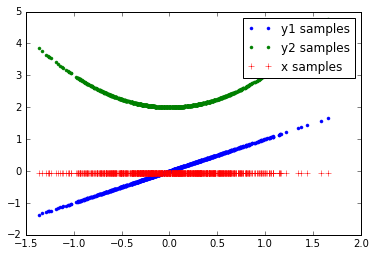

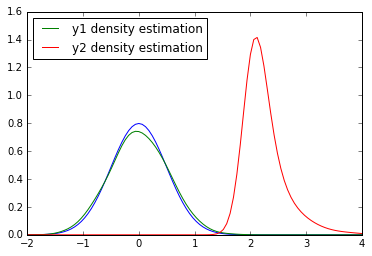

In [2]:
def func(x):
    return x, x**2+2

N = 1000 #number of samples
a = np.random.normal(0, 0.5, N)

y1_true, y2_true = func(a)

plt.plot(a,y1_true,'b.', label='y1 samples')
plt.plot(a,y2_true,'g.', label='y2 samples')
plt.plot(a, -0.05 - 0.01 * np.random.random(a.shape[0]), '+r', label='x samples')
plt.legend()

plt.figure()

X_plot = np.linspace(-2, 4, 100)[:, np.newaxis]
kde_y1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y1_true[:,None])
kde_y2 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y2_true[:,None])

y1_dens = norm(0, 0.5).pdf(X_plot[:, 0])
y2_dens = norm(2, 0.5).pdf(X_plot[:, 0])
plt.plot(X_plot,y1_dens)
plt.plot(X_plot,np.exp(kde_y1.score_samples(X_plot)), label='y1 density estimation')
plt.plot(X_plot,np.exp(kde_y2.score_samples(X_plot)), label='y2 density estimation')
plt.legend(loc='best')

In [3]:
#simulating a bad regressor for y1 and good for y2
y1_pred = y1_true + 0.7 * np.random.random(y1_true.shape[0]) #add noise to 
y2_pred = y2_true + 0.1 * np.random.random(y2_true.shape[0])

y_true = np.vstack((y1_true, y2_true)).T
y_pred = np.vstack((y1_pred, y2_pred)).T


print 'raw values:        ', r2_score(y_true, y_pred, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true, y_pred, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true, y_pred, multioutput='variance_weighted')

raw values:         [ 0.32674355  0.97210487]
uniform average:    0.649424208905
variance_weighted:  0.530870431454


In [4]:
#simulating a bad regressor for y2 and good for y1
y1_pred = y1_true + 0.1 * np.random.random(y1_true.shape[0])
y2_pred = y2_true + 0.5 * np.random.random(y2_true.shape[0])

y_true = np.vstack((y1_true, y2_true)).T
y_pred = np.vstack((y1_pred, y2_pred)).T


print 'raw values:        ', r2_score(y_true, y_pred, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true, y_pred, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true, y_pred, multioutput='variance_weighted')

raw values:         [ 0.98605018  0.30611918]
uniform average:    0.64608467739
variance_weighted:  0.77098895414


In [5]:
print np.var(y1_true)
print np.var(y2_true)
print np.average(r2_score(y_true, y_pred, multioutput='raw_values'), weights=(np.var(y1_true),np.var(y2_true)))

0.24589517537
0.113757701746
0.77098895414


## Normalization

In [6]:
##mean removal and variance scaling
y_all = np.hstack((y_true,y_pred))
y_all_norm = preprocessing.scale(y_all)

y_true_norm = y_all_norm[:,0:2]#preprocessing.scale(y_true)
y_pred_norm = y_all_norm[:,2:4]#preprocessing.scale(y_pred)

print 'raw values:        ', r2_score(y_true_norm, y_pred_norm, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true_norm, y_pred_norm, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true_norm, y_pred_norm, multioutput='variance_weighted')

raw values:         [ 0.99653412  0.83148724]
uniform average:    0.914010677428
variance_weighted:  0.914010677428


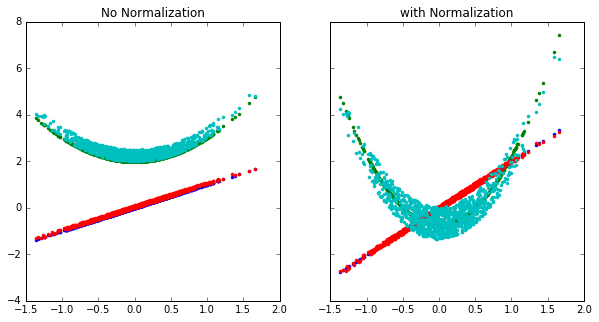

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,5))
ax1.set_title('No Normalization')
ax1.plot(a,y_true[:,0],'.')
ax1.plot(a,y_true[:,1],'.')
ax1.plot(a,y_pred[:,0],'.')
ax1.plot(a,y_pred[:,1],'.')
ax2.set_title('with Normalization')
ax2.plot(a,y_true_norm[:,0],'.')
ax2.plot(a,y_true_norm[:,1],'.')
ax2.plot(a,y_pred_norm[:,0],'.')
ax2.plot(a,y_pred_norm[:,1],'.')

In [8]:
##scaling individual samples to have unit norm
y_all = np.hstack((y_true,y_pred))
y_all_norm = preprocessing.normalize(y_all,norm='l2',axis=0)

y_true_norm = y_all_norm[:,0:2]#preprocessing.normalize(y_true,norm='l2',axis=0)
y_pred_norm = y_all_norm[:,2:4]#preprocessing.normalize(y_pred,norm='l2',axis=0)

print 'raw values:        ', r2_score(y_true_norm, y_pred_norm, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true_norm, y_pred_norm, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true_norm, y_pred_norm, multioutput='variance_weighted')

raw values:         [ 0.98624487  0.83503744]
uniform average:    0.91064115812
variance_weighted:  0.98298140285


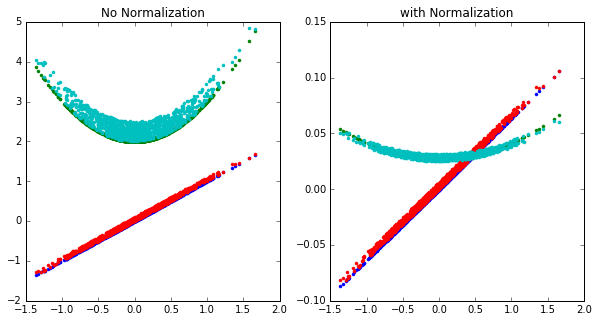

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.set_title('No Normalization')
ax1.plot(a,y_true[:,0],'.')
ax1.plot(a,y_true[:,1],'.')
ax1.plot(a,y_pred[:,0],'.')
ax1.plot(a,y_pred[:,1],'.')
ax2.set_title('with Normalization')
ax2.plot(a,y_true_norm[:,0],'.')
ax2.plot(a,y_true_norm[:,1],'.')
ax2.plot(a,y_pred_norm[:,0],'.')
ax2.plot(a,y_pred_norm[:,1],'.')

## conclusion: normalization is a bad idea!!!